In [1]:
type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

## Solve an inverse tarffic problem over polynomials of degree at most d

## Optionally use a regularizer from the poly kernel

In [2]:
using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
    @defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in the demand file
file = open("East_Massachusetts_trips_Jan_PM.txt")
demands = Dict{(Int64,Int64), Float64}()
s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand 
            end
        end
    end
end                
close(file)

In [10]:
############
#read in the arc files
arcs = Dict{(Int, Int), Arc}()
file = open("East_Massachusetts_net_Jan_PM.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), float(vals[3]), float(vals[5]))
end
close(file)

In [11]:
###########
#read in the initial flows

# file = open("../data_original/SiouxFallsFlow.txt")

file = open("flows_converge.txt")

ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow = float(vals[3])
end
close(file)

In [12]:
##########
# Set up demand data and flow data
##########

flow_data = Array(Float64, length(arcs))
flows = Dict{(Int64,Int64), Float64}()
demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs)
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end

for odpair in keys(demands)
    if ! haskey(demand_data, odpair)
        demand_data[odpair] = [demands[odpair], ]
    else
        push!(demand_data[odpair], demands[odpair])
    end
end

flow_data = [a.flow::Float64 for a in vArcs]

for a in vArcs
    flows[(a.initNode, a.termNode)] = a.flow
end

In [13]:
flows

Dict{(Int64,Int64),Float64} with 24 entries:
  (3,6) => 12580.962888630183
  (2,3) => 8000.00001029226
  (5,6) => 6000.000000436973
  (5,4) => 15000.00009002714
  (2,1) => 12098.207512248424
  (6,3) => 12372.816065472918
  (3,1) => 12901.792487193356
  (4,5) => 15398.718808036634
  (1,3) => 12550.538648183572
  (4,8) => 17449.46143133243
  (7,5) => 20130.257615025897
  (8,7) => 26503.07367999163
  (3,2) => 8000.0000012240125
  (7,6) => 14372.816065090396
  (2,4) => 17449.4613410048
  (7,8) => 26550.538568039785
  (6,5) => 6000.000000432818
  (6,7) => 14580.962888247637
  (8,4) => 17496.926319379065
  (1,2) => 12449.46135126259
  (5,3) => 15528.976422877002
  (4,2) => 17098.20751103876
  (3,5) => 14969.57576976304
  (5,7) => 19969.575679915495

In [14]:
#load node-link incidence
using JSON

nodeLink = readall("node_link_incidence_MA.json");
nodeLink = JSON.parse(nodeLink);

In [15]:
nodeLink["2-21"]

0.0

In [16]:
link_label_dict = readall("link_label_dict_MA.json");
link_label_dict = JSON.parse(link_label_dict);

In [17]:
link_label_dict["1"]

int(split(link_label_dict["1"], ',')[1]), int(split(link_label_dict["1"], ',')[2])

flows[int(split(link_label_dict["1"], ',')[1]), int(split(link_label_dict["1"], ',')[2])]

string(1)

"1"

In [18]:
function addResid_(m, coeffs, ys, demands_, demands, arcs, scaling)
    @defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

    for (s,t)=keys(demands)
        @addConstraint(m, demands_[(s,t)] >= 0)
    end

	@addConstraint(m, dual_cost == sum{demands_[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid_ (generic function with 1 method)

In [19]:
##########
#Fitting Funcs
##########

function train_cy(lam::Float64, deg::Int, c::Float64, demands, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    

    #copy the flow data over to the arcs
    for (ix, a) in enumerate(vArcs)
        a.flow = flow_data[ix]
    end

    #Dual Feasibility
    ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)

    #add the residual for this data point
    push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))


    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    return [getValue(coeffs[i]) for i =1:length(coeffs)], getValue(ys), getValue(resids)
end

train_cy (generic function with 1 method)

In [20]:
nodeLink["0-23"]

0.0

In [21]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 3000.0
  (4,4) => 0.0
  (3,1) => 1000.0
  (4,5) => 5000.0
  (2,4) => 2000.0
  (6,5) => 2000.0
  (8,4) => 7000.0
  (1,2) => 1000.0
  (5,1) => 2000.0
  (3,4) => 2000.0
  (8,2) => 4000.0
  (2,3) => 1000.0
  (2,6) => 4000.0
  (5,4) => 5000.0
  (2,1) => 1000.0
  (2,5) => 1000.0
  (8,5) => 5000.0
  (1,4) => 5000.0
  (2,8) => 4000.0
  (5,8) => 5000.0
  (4,8) => 7000.0
  (7,8) => 10000.0
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 2000.0
  ⋮     => ⋮

In [22]:
outfile = open("demands_MA.json", "w")

JSON.print(outfile, demands)

close(outfile)

In [23]:
##########
#Fitting Funcs
##########

function train_cd(lam::Float64, deg::Int, c::Float64, ys, flow_data, flows, nodeLink, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)

    resids = Variable[]
    

    #copy the flow data over to the arcs
    for (ix, a) in enumerate(vArcs)
        a.flow = flow_data[ix]
    end

    for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end

    @defVar(m, demands_[keys(demands)])
    
    for (s,t) = keys(demands)
        @addConstraint(m, demands_[(s,t)] >= 0)
        @addConstraint(m, demands_[(s,t)] - demands[(s,t)] <= demands[(s,t)] * 0.1)
        @addConstraint(m, demands[(s,t)] - demands_[(s,t)] <= demands[(s,t)] * 0.1)
    end
    
#     numLinks = length(flows)  # number of links
#     @defVar(m, odLinkFlow[keys(demands), 1:numLinks])
#     for (s,t) = keys(demands)
#         for k = 1:numLinks
#             @addConstraint(m, odLinkFlow[(s,t), k] >= 0)
#         end
#     end
    
#     for k = 1:numLinks
#         linkFlowPartial = 0
#         for (s,t) = keys(demands)
#             linkFlowPartial += odLinkFlow[(s,t), k]
#         end
#         key = (int(split(link_label_dict["$(k-1)"], ',')[1]), int(split(link_label_dict["$(k-1)"], ',')[2]))
#         @addConstraint(m, linkFlowPartial - flows[key] <= 2e3)
#         @addConstraint(m, flows[key] - linkFlowPartial <= 2e3)
#     end

#     for l = 1:numNodes
#         for (s,t) = keys(demands)
#             if s == t
#                 @addConstraint(m, demands_[(s,t)] == 0)
#             else
#                 odLinkFlowPartial = 0
#                 for k = 1:numLinks
#                     odLinkFlowPartial += nodeLink["$(l-1)-$(k-1)"] * odLinkFlow[(s,t), k]
#                 end

#                 if (l+1 == s)
#                     @addConstraint(m, odLinkFlowPartial + demands_[(s,t)] == 0)
#                 elseif (l+1 == t)
#                     @addConstraint(m, odLinkFlowPartial - demands_[(s,t)] == 0)
#                 else
#                     @addConstraint(m, odLinkFlowPartial == 0)
#                 end
#             end
#         end
#     end
    
    #add the residual for this data point
    push!(resids, addResid_(m, coeffs, ys, demands_, demands, arcs, 1e6))

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    return [getValue(coeffs[i]) for i =1:length(coeffs)], getValue(demands_), getValue(resids)
end

train_cd (generic function with 1 method)

In [24]:
demands[(1, 1)]

0.0

In [25]:
#include("trafficCval.jl")

coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

deg = 8
c = .5
lam = 10000.

demands_0 = copy(demands)

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 3000.0
  (4,4) => 0.0
  (3,1) => 1000.0
  (4,5) => 5000.0
  (2,4) => 2000.0
  (6,5) => 2000.0
  (8,4) => 7000.0
  (1,2) => 1000.0
  (5,1) => 2000.0
  (3,4) => 2000.0
  (8,2) => 4000.0
  (2,3) => 1000.0
  (2,6) => 4000.0
  (5,4) => 5000.0
  (2,1) => 1000.0
  (2,5) => 1000.0
  (8,5) => 5000.0
  (1,4) => 5000.0
  (2,8) => 4000.0
  (5,8) => 5000.0
  (4,8) => 7000.0
  (7,8) => 10000.0
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 2000.0
  ⋮     => ⋮

In [26]:
flows

Dict{(Int64,Int64),Float64} with 24 entries:
  (3,6) => 12580.962888630183
  (2,3) => 8000.00001029226
  (5,6) => 6000.000000436973
  (5,4) => 15000.00009002714
  (2,1) => 12098.207512248424
  (6,3) => 12372.816065472918
  (3,1) => 12901.792487193356
  (4,5) => 15398.718808036634
  (1,3) => 12550.538648183572
  (4,8) => 17449.46143133243
  (7,5) => 20130.257615025897
  (8,7) => 26503.07367999163
  (3,2) => 8000.0000012240125
  (7,6) => 14372.816065090396
  (2,4) => 17449.4613410048
  (7,8) => 26550.538568039785
  (6,5) => 6000.000000432818
  (6,7) => 14580.962888247637
  (8,4) => 17496.926319379065
  (1,2) => 12449.46135126259
  (5,3) => 15528.976422877002
  (4,2) => 17098.20751103876
  (3,5) => 14969.57576976304
  (5,7) => 19969.575679915495

In [27]:
fcoeffs, ys, resids = train_cy(lam, deg, c, demands_0, flow_data, arcs)
coeffs_dict[(deg, c, lam)] = fcoeffs

9-element Array{Float64,1}:
  1.0       
 -0.00677008
  0.0728343 
 -0.399166  
  1.26083   
 -2.33677   
  2.54313   
 -1.47196   
  0.359354  

In [42]:
fcoeffs, demands_, resides_ = train_cd(lam, deg, c, ys, flow_data, flows, nodeLink, arcs)
for (s,t) = keys(demands)
    demands_0[(s,t)] = demands_[(s,t)]
end
coeffs_dict[(deg, c, lam)] = fcoeffs

5-element Array{Float64,1}:
 1.0        
 0.00311707 
 0.00289664 
 0.000594741
 0.000339645

INFO: Loading help data...


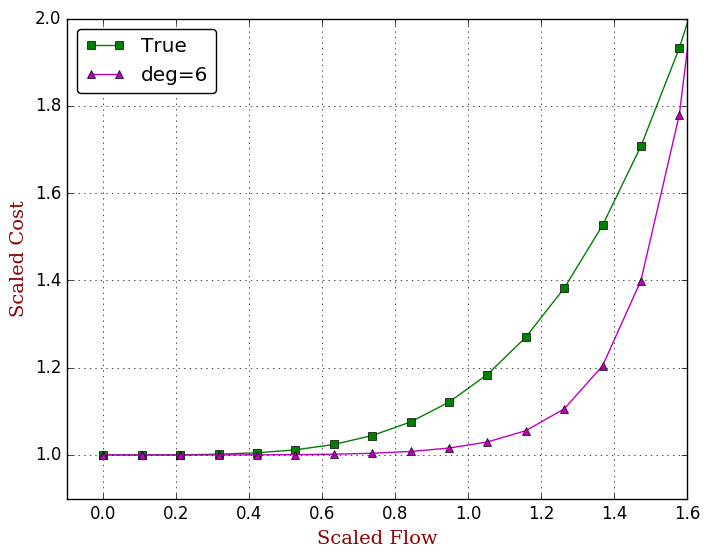

In [28]:
using PyPlot

true_coeffs = [1, 0, 0, 0, .15]

fcoeffs = coeffs_dict[(8, .5, 10000.)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(fcoeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("fitting_MA.pdf")

In [29]:
demands_0

Dict{(Int64,Int64),Float64} with 576 entries:
  (23,8)  => 270.0
  (8,23)  => 270.0
  (6,9)   => 440.0
  (18,3)  => -0.0
  (21,13) => 540.0
  (22,16) => 1320.0
  (15,17) => 1650.0
  (22,14) => 1320.0
  (13,9)  => 660.0
  (23,10) => 1620.0
  (24,22) => 1210.0
  (8,9)   => 880.0
  (9,1)   => 550.0
  (17,14) => 770.0
  (16,6)  => 990.0
  (16,12) => 630.0
  (16,13) => 540.0
  (22,2)  => 90.0
  (24,3)  => -0.0
  (7,16)  => 1540.0
  (1,12)  => 220.0
  (4,5)   => 550.0
  (11,8)  => 720.0
  (18,21) => 110.0
  (19,4)  => 180.0
  ⋮        => ⋮